# Feature Engineering

1. Select low/high-variance variables
2. Dropping redundant variables
3. RFE

In [1]:
import pandas as pd
import dslabs_functions as dslabs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import subplots, show
from matplotlib.pyplot import savefig, figure

## tratar da primeira coluna nos notebooks anteriores
winning_alternative_scaling = 2
folder = "feat_eng_csvs"
filename = f'../data_preparation_csvs/scaling_csvs/data_scaled_zscore_alt1.csv'
data_scaling: pd.DataFrame = pd.read_csv(filename, sep=',', decimal='.', na_values='')
print(f"Dataset nr records={data_scaling.shape[0]}", f"nr variables={data_scaling.shape[1]}")
filename_prefix = "../data_preparation_csvs/outliers_treatment_csvs/feature_eng_"

train = pd.read_csv('../data_preparation_csvs/scaling_csvs/train_data_scaled_zscore_alt1.csv')
test = pd.read_csv('../data_preparation_csvs/scaling_csvs/test_data_scaled_zscore_alt1.csv')

Dataset nr records=100000 nr variables=32


In [9]:
# Save to file
def save(df, name):
    df.to_csv(f'{filename_prefix}{name}_data.csv', index=False)

    ## Separate into Train and Test and save in different files
    train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

    ## Save the training and testing sets to CSV files
    train_data.to_csv(f'../data_preparation_csvs/{folder}/train_data_mv_{name}.csv', index=False)
    test_data.to_csv(f'../data_preparation_csvs/{folder}/test_data_mv_{name}.csv', index=False)

    ## Evaluate Approach
    file_tag = "Credit_Score"
    target = "Credit_Score"

    figure()
    eval: dict[str, list] = dslabs.evaluate_approach(train_data, test_data, target=target, metric="recall")
    dslabs.plot_multibar_chart(
        ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
    )
    savefig(f"../data_preparation_images/feat_eng_result/data_mv_{name}_eval.png")
    show()

In [4]:
target = "Credit_Score"      # This method doesn't work when using zscore scaling for obvious reasons
file_tag = "Credit_Score"
print("Original variables", train.columns.to_list())
vars2drop: list[str] = dslabs.select_low_variance_variables(train, 0.015, target=target)
print("Variables to drop", vars2drop)
print(len(vars2drop), len(train.columns))

Original variables ['Month', 'Occupation', 'Payment_of_Min_Amount', 'CreditMix', 'Payment_Behaviour', 'Payday Loan', 'Personal Loan', 'Debt Consolidation Loan', 'Auto Loan', 'Not Specified Loan', 'Student Loan', 'Credit-Builder Loan', 'Mortgage Loan', 'Home Equity Loan', 'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'NumofLoan', 'Delay_from_due_date', 'NumofDelayedPayment', 'ChangedCreditLimit', 'NumCreditInquiries', 'OutstandingDebt', 'CreditUtilizationRatio', 'Credit_History_Age', 'TotalEMIpermonth', 'Amountinvestedmonthly', 'MonthlyBalance', 'Credit_Score']
Variables to drop []
0 32


In [ ]:
target = "Credit_Score"
file_tag = "Credit_Score"

eval_metric = "recall"
figure(figsize=(2 * dslabs.HEIGHT, dslabs.HEIGHT))
print(dslabs.study_variance_for_feature_selection(
    train,
    test,
    target=target,
    max_threshold=0.015,
    lag=0.01,
    metric=eval_metric,
    file_tag=file_tag,
))
show()

In [ ]:
vals = pd.DataFrame(data={'NB': [0.8305960639954694, 0.8717966869602152, 0.8874415970550757, 0.8874415970550757, 0.8873000141582896, 0.8873708056066827, 0.8908395865779414, 0.8908395865779414, 0.8905564207843693, 0.8905564207843693], 'KNN': [0.8912643352682996, 0.8824861956675634, 0.877530794280051, 0.877601585728444, 0.8785926660059464, 0.8948746991363443, 0.8945207418943791, 0.8945207418943791, 0.9318278351975081, 0.9318278351975081]}
)

print(vals["KNN"])

In [5]:
print("Original variables", train.columns.values)
vars2drop: list[str] = dslabs.select_redundant_variables(
    train, target=target, min_threshold=0.54
)
print("Variables to drop", vars2drop)

Original variables ['Month' 'Occupation' 'Payment_of_Min_Amount' 'CreditMix'
 'Payment_Behaviour' 'Payday Loan' 'Personal Loan'
 'Debt Consolidation Loan' 'Auto Loan' 'Not Specified Loan' 'Student Loan'
 'Credit-Builder Loan' 'Mortgage Loan' 'Home Equity Loan' 'Age'
 'Annual_Income' 'Monthly_Inhand_Salary' 'Num_Bank_Accounts'
 'Num_Credit_Card' 'Interest_Rate' 'NumofLoan' 'Delay_from_due_date'
 'NumofDelayedPayment' 'ChangedCreditLimit' 'NumCreditInquiries'
 'OutstandingDebt' 'CreditUtilizationRatio' 'Credit_History_Age'
 'TotalEMIpermonth' 'Amountinvestedmonthly' 'MonthlyBalance'
 'Credit_Score']
Variables to drop ['Payment_of_Min_Amount', 'Delay_from_due_date']


In [11]:
from math import ceil


options: list[float] = [
    round(0.5 + i * 0.01, 3)
    for i in range(ceil((1 - 0.5) / 0.01) + 1)
]
                                                # OPTIMAL VALUE: 0.54 (2 cols dropped)

vars2drop: list[str] = dslabs.select_redundant_variables(
    train, target=target, min_threshold=0.54
)
print("Variables to drop", vars2drop)
df = train.copy()
df.drop(columns=vars2drop)

Variables to drop ['Payment_of_Min_Amount', 'Delay_from_due_date']


,Month,Occupation,CreditMix,Payment_Behaviour,Payday Loan,Personal Loan,Debt Consolidation Loan,Auto Loan,Not Specified Loan,Student Loan,...,NumofDelayedPayment,ChangedCreditLimit,NumCreditInquiries,OutstandingDebt,CreditUtilizationRatio,Credit_History_Age,TotalEMIpermonth,Amountinvestedmonthly,MonthlyBalance,Credit_Score
0,0.617213,1.643545,1.442759,1.027891,-0.610709,0.946532,-0.601108,-0.593465,-0.608615,-0.599529,...,-0.830293,-0.843774,-0.189520,-0.176902,0.021285,0.794392,-0.043455,-0.397212,-0.176634,1.0
1,0.308607,-0.265636,1.442759,1.561849,-0.610709,-0.602316,0.949098,-0.593465,0.927671,-0.599529,...,-0.388871,-0.613026,-0.520754,-0.583249,1.591113,1.347304,0.204028,-0.124680,2.212581,1.0
2,1.234427,-1.220227,-0.081518,-1.107942,-0.610709,-0.602316,0.949098,-0.593465,-0.608615,0.938988,...,-0.609582,-1.410652,-0.189520,-0.905566,-1.732614,1.059790,0.108427,-0.284188,-0.813926,1.0
3,-0.617213,-0.504284,-0.081518,-0.040026,-0.610709,-0.602316,0.949098,0.968614,-0.608615,0.938988,...,-0.057804,0.295432,-0.272329,-1.250557,-1.029615,-0.068151,-0.126613,-0.444947,-0.479944,1.0
4,-2.160247,1.404898,1.442759,1.027891,-0.610709,-0.602316,-0.601108,0.968614,-0.608615,-0.599529,...,-0.499226,0.059233,-0.437946,-0.573035,-1.208908,0.728043,-0.173926,-0.643582,-0.011494,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,-0.308607,-1.697523,1.442759,0.493933,-0.610709,-0.602316,-0.601108,0.968614,0.927671,-0.599529,...,-0.499226,-0.738393,-0.437946,-1.323545,0.590988,0.562169,0.009936,1.304137,-0.310707,1.0
79996,1.234427,-0.265636,-0.081518,-1.107942,-0.610709,-0.602316,-0.601108,0.968614,-0.608615,0.938988,...,0.273262,0.702421,-0.023903,0.096496,0.276669,-0.709529,-0.169768,-0.419241,-0.409536,0.0
79997,0.617213,-0.504284,-0.081518,-0.573984,0.894687,-0.602316,-0.601108,-0.593465,-0.608615,2.477505,...,-0.388871,-0.990945,-0.189520,-0.729033,1.166061,1.236722,0.003971,0.911475,-0.308434,1.0
79998,0.617213,-0.981580,-0.081518,-0.040026,-0.610709,-0.602316,2.499305,-0.593465,-0.608615,-0.599529,...,-0.499226,-1.038184,-0.355137,-1.044428,0.932893,-0.278257,-0.148143,-0.106849,-0.756176,1.0


In [12]:
eval_metric = "recall"

new_train = train.copy()
new_train.drop(columns=vars2drop)
new_test = train.copy()
new_test.drop(columns=vars2drop)

figure(figsize=(2 * dslabs.HEIGHT, dslabs.HEIGHT))
print(dslabs.study_redundancy_for_feature_selection(
    new_train,
    new_test,
    target=target,                      # RECALL DE 1 NO KNN WTF NNGAGNGNAGNANGANGA
    metric=eval_metric,
    file_tag=file_tag,
))
show()

{'NB': [0.8443983402489627], 'KNN': [1.0]}


<Figure size 1200x600 with 0 Axes>

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
99995    0.0
99996    0.0
99997    0.0
99998    1.0
99999    0.0
Name: Credit_Score, Length: 100000, dtype: float64
Selected Features for LogisticRegression:
Index(['Payment_of_Min_Amount', 'Payment_Behaviour', 'Payday Loan',
       'Debt Consolidation Loan', 'Auto Loan', 'Not Specified Loan',
       'Student Loan', 'Age', 'Interest_Rate', 'Delay_from_due_date',
       'ChangedCreditLimit', 'NumCreditInquiries', 'OutstandingDebt',
       'Credit_History_Age', 'Amountinvestedmonthly', 'Credit_Score'],
      dtype='object')




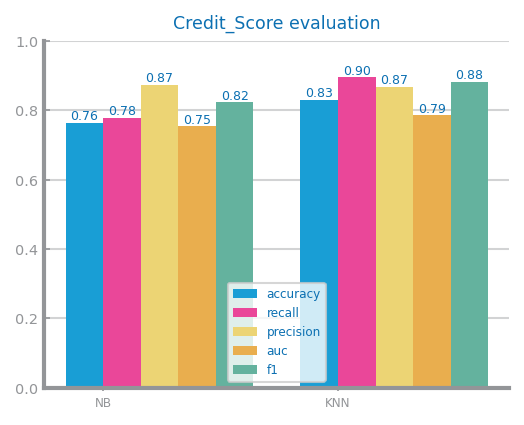

Selected Features for RandomForestClassifier:
Index(['Payment_of_Min_Amount', 'CreditMix', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'NumofLoan', 'Delay_from_due_date',
       'NumofDelayedPayment', 'ChangedCreditLimit', 'NumCreditInquiries',
       'OutstandingDebt', 'Credit_History_Age', 'TotalEMIpermonth',
       'Credit_Score'],
      dtype='object')




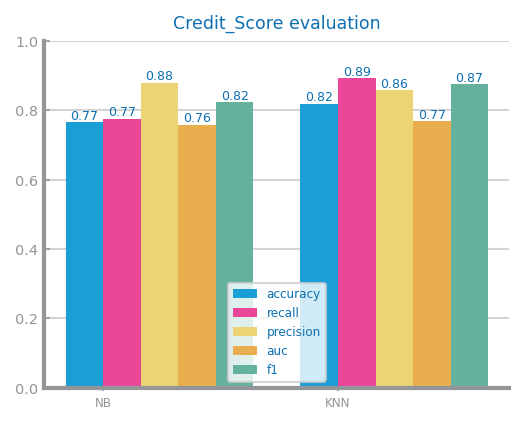

Selected Features for GradientBoostingClassifier:
Index(['Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'NumofLoan', 'Delay_from_due_date',
       'NumofDelayedPayment', 'ChangedCreditLimit', 'OutstandingDebt',
       'CreditUtilizationRatio', 'Credit_History_Age', 'TotalEMIpermonth',
       'Amountinvestedmonthly', 'MonthlyBalance', 'Credit_Score'],
      dtype='object')




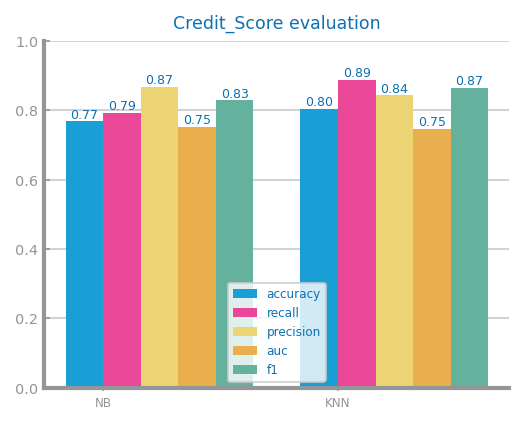

In [10]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
import pandas as pd

# Assuming your data is loaded into a pandas DataFrame 'data'
# 'target_column' refers to the column you want to predict/classify

# Replace these with your actual data and target column
target = 'Credit_Score'  # Your target column name

X = data_scaling.copy()
print(X["Credit_Score"])
X.drop(columns=["Credit_Score"])

y = data_scaling[target]

# List of models to test
models = [
    LogisticRegression(),                                       # GANHA ESTE
    RandomForestClassifier(),
    GradientBoostingClassifier()
]

# Iterate through each model and perform RFE
for model in models:
    model_name = model.__class__.__name__
    rfe = RFE(model)  # Adjust the number of features as needed
    rfe.fit(X, y)
    selected_features = X.columns[rfe.support_]
    vars2drop = X.columns[~rfe.support_]
    print(f"Selected Features for {model_name}:")
    print(selected_features)
    print("\n")
    save(data_scaling[selected_features], "alt3")